## 1. Setup and Configuration

# Model Evaluation and Hyperparameter Calibration

This notebook performs comprehensive model evaluation:
1. **Validation Set**: Quick metrics evaluation and hyperparameter calibration (conf, IoU)
2. **Test Set**: Detailed evaluation with visualizations and final performance metrics
3. **Wandb Integration**: Logging all metrics and visualizations to Weights & Biases

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

try:
    import wandb
    from PRIVATE import WANDB_API_KEY
    WANDB_AVAILABLE = True
except ImportError:
    print("Wandb not available or PRIVATE.py not found. Continuing without wandb logging.")
    WANDB_AVAILABLE = False

# Set random seeds for reproducibility
np.random.seed(42)

# Set up matplotlib defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


### 1.1 Select Experiment and Model

In [11]:
# ============================================================================
# CONFIGURATION - MODIFY THIS SECTION
# ============================================================================

# Experiment name (folder name in DeTect-BMMS/runs/)
EXPERIMENT_NAME = "yolov26n-default-singlecls-bgundersampled-DeTect700-v1"

# Model configuration
SINGLE_CLS = True  # Set to True if trained with single_cls=True
IMGSZ = 640
BATCH_SIZE = 16

# Dataset paths
DATASET_YAML = "cfg/datasets/DeTect.yaml"
MODELS_DIR = Path("DeTect-BMMS/runs")

# Class names from DeTect dataset
CLASS_NAMES = {
    0: 'bat',
    1: 'bird',
    2: 'insect',
    3: 'drone',
    4: 'plane',
    5: 'other',
    6: 'unknown'
}

# ============================================================================

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Single Class Mode: {SINGLE_CLS}")
print(f"Dataset: {DATASET_YAML}")

Experiment: yolov26n-default-singlecls-bgundersampled-DeTect700-v1
Single Class Mode: True
Dataset: cfg/datasets/DeTect.yaml


### 1.2 Load Model

In [12]:
# Load the best model from the experiment
model_path = MODELS_DIR / EXPERIMENT_NAME / "weights" / "best.pt"

if not model_path.exists():
    raise FileNotFoundError(f"Model not found at: {model_path}")

print(f"Loading model from: {model_path}")
model = YOLO(str(model_path))
print(f"✓ Model loaded successfully!")

# Display model information
print(f"\nModel details:")
print(f"  Architecture: {model.model_name if hasattr(model, 'model_name') else 'YOLO'}")
print(f"  Task: {model.task if hasattr(model, 'task') else 'detect'}")
print(f"  Classes: {len(CLASS_NAMES)}")

Loading model from: DeTect-BMMS\runs\yolov26n-default-singlecls-bgundersampled-DeTect700-v1\weights\best.pt
✓ Model loaded successfully!

Model details:
  Architecture: DeTect-BMMS\runs\yolov26n-default-singlecls-bgundersampled-DeTect700-v1\weights\best.pt
  Task: detect
  Classes: 7


### 1.3 Initialize Wandb (Optional)

In [13]:
# Initialize wandb for experiment tracking
if WANDB_AVAILABLE:
    try:
        wandb.login(key=WANDB_API_KEY)
        
        # Initialize wandb run
        wandb.init(
            project="DeTect-Taiwan-Birds",
            name=f"eval_{EXPERIMENT_NAME}",
            config={
                "experiment": EXPERIMENT_NAME,
                "model_path": str(model_path),
                "single_cls": SINGLE_CLS,
                "imgsz": IMGSZ,
                "batch_size": BATCH_SIZE,
                "dataset": DATASET_YAML
            },
            tags=["evaluation", "validation", "test"]
        )
        print("✓ Wandb initialized successfully!")
    except Exception as e:
        print(f"Warning: Could not initialize wandb: {e}")
        WANDB_AVAILABLE = False
else:
    print("Wandb not available - continuing without logging")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_best_conf,▁
val_best_f1,▁
val_best_iou,▁
val_best_map50,▁
val_best_conf,0.1
val_best_f1,0.56332
val_best_iou,0.3
val_best_map50,0.49645


✓ Wandb initialized successfully!


## 2. Validation Set Evaluation (Hyperparameter Calibration)

### 2.1 Baseline Validation Metrics

In [5]:
print("=" * 80)
print("VALIDATION SET - BASELINE EVALUATION")
print("=" * 80)

# Run validation without saving images (quick baseline)
val_results = model.val(
    data=DATASET_YAML,
    split='val',
    conf=0.25,  # Default confidence threshold
    iou=0.45,   # Default IoU threshold for NMS
    single_cls=SINGLE_CLS,
    imgsz=IMGSZ,
    batch=BATCH_SIZE,
    save_json=False,
    save_hybrid=False,
    plots=False,  # No plots to save time
    verbose=True
)

# Extract metrics
val_metrics = {
    'mAP50': float(val_results.box.map50) if hasattr(val_results.box, 'map50') else 0.0,
    'mAP50-95': float(val_results.box.map) if hasattr(val_results.box, 'map') else 0.0,
    'precision': float(val_results.box.p.mean()) if hasattr(val_results.box, 'p') else 0.0,
    'recall': float(val_results.box.r.mean()) if hasattr(val_results.box, 'r') else 0.0,
}

print(f"\n{'Metric':<20} {'Value':<10}")
print("-" * 30)
for metric, value in val_metrics.items():
    print(f"{metric:<20} {value:.4f}")

# Log to wandb
if WANDB_AVAILABLE:
    wandb.log({"val_baseline": val_metrics})
    
print("\n✓ Baseline validation complete!")

VALIDATION SET - BASELINE EVALUATION
WARNING 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.4.2  Python-3.11.14 torch-2.9.1+cpu CPU (Intel Xeon E-2176G CPU @ 3.70GHz)
YOLO26n summary (fused): 122 layers, 2,375,031 parameters, 0 gradients, 5.2 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 476.9101.2 MB/s, size: 128.1 KB)
val: Scanning G:\2025-05-14_videos_annotated\labels.cache... 133 images, 365 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 498/498  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 1.5s/it 47.6s1.5ss
                   all        498        140       0.67      0.464      0.514       0.18
Speed: 0.8ms preprocess, 51.9ms inference, 0.0ms loss, 0.3ms postprocess per image

Metric               Value     
------------------------------
mAP50                0.5141
mAP50-95             0.1799
precision            0.6701
recall               0.4643

✓ Baseline validation co

### 2.2 Confidence Threshold Calibration on Validation Set

In [6]:
print("\n" + "=" * 80)
print("CONFIDENCE THRESHOLD CALIBRATION (Validation Set)")
print("=" * 80)

# Test different confidence thresholds
conf_thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8]
conf_results = []

for conf in conf_thresholds:
    print(f"\nTesting conf={conf:.2f}...")
    
    results = model.val(
        data=DATASET_YAML,
        split='val',
        conf=conf,
        iou=0.45,
        single_cls=SINGLE_CLS,
        imgsz=IMGSZ,
        batch=BATCH_SIZE,
        save_json=False,
        plots=False,
        verbose=False
    )
    
    conf_results.append({
        'conf': conf,
        'mAP50': float(results.box.map50) if hasattr(results.box, 'map50') else 0.0,
        'mAP50-95': float(results.box.map) if hasattr(results.box, 'map') else 0.0,
        'precision': float(results.box.p.mean()) if hasattr(results.box, 'p') else 0.0,
        'recall': float(results.box.r.mean()) if hasattr(results.box, 'r') else 0.0,
    })

conf_df = pd.DataFrame(conf_results)
print("\n" + conf_df.to_string(index=False))

# Find best confidence threshold based on F1 score
conf_df['f1'] = 2 * (conf_df['precision'] * conf_df['recall']) / (conf_df['precision'] + conf_df['recall'] + 1e-10)
best_conf_idx = conf_df['f1'].idxmax()
best_conf = conf_df.loc[best_conf_idx, 'conf']
print(f"\n✓ Best confidence threshold: {best_conf:.2f} (F1={conf_df.loc[best_conf_idx, 'f1']:.4f})")

# Log to wandb
if WANDB_AVAILABLE:
    wandb.log({
        "val_best_conf": best_conf,
        "val_best_f1": conf_df.loc[best_conf_idx, 'f1']
    })
    
    # Log confidence calibration table
    wandb.log({"val_conf_calibration": wandb.Table(dataframe=conf_df)})


CONFIDENCE THRESHOLD CALIBRATION (Validation Set)

Testing conf=0.10...
Ultralytics 8.4.2  Python-3.11.14 torch-2.9.1+cpu CPU (Intel Xeon E-2176G CPU @ 3.70GHz)
val: Fast image access  (ping: 0.10.0 ms, read: 309.3119.9 MB/s, size: 154.3 KB)
val: Scanning G:\2025-05-14_videos_annotated\labels.cache... 133 images, 365 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 498/498  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 1.6s/it 51.1s1.4ss
                   all        498        140      0.606      0.527      0.496       0.17
Speed: 1.4ms preprocess, 79.6ms inference, 0.0ms loss, 0.2ms postprocess per image

Testing conf=0.15...
Ultralytics 8.4.2  Python-3.11.14 torch-2.9.1+cpu CPU (Intel Xeon E-2176G CPU @ 3.70GHz)
val: Fast image access  (ping: 0.10.0 ms, read: 522.3127.1 MB/s, size: 124.3 KB)
val: Scanning G:\2025-05-14_videos_annotated\labels.cache... 133 images, 365 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 498/498 

### 2.3 Visualize Confidence Threshold Impact

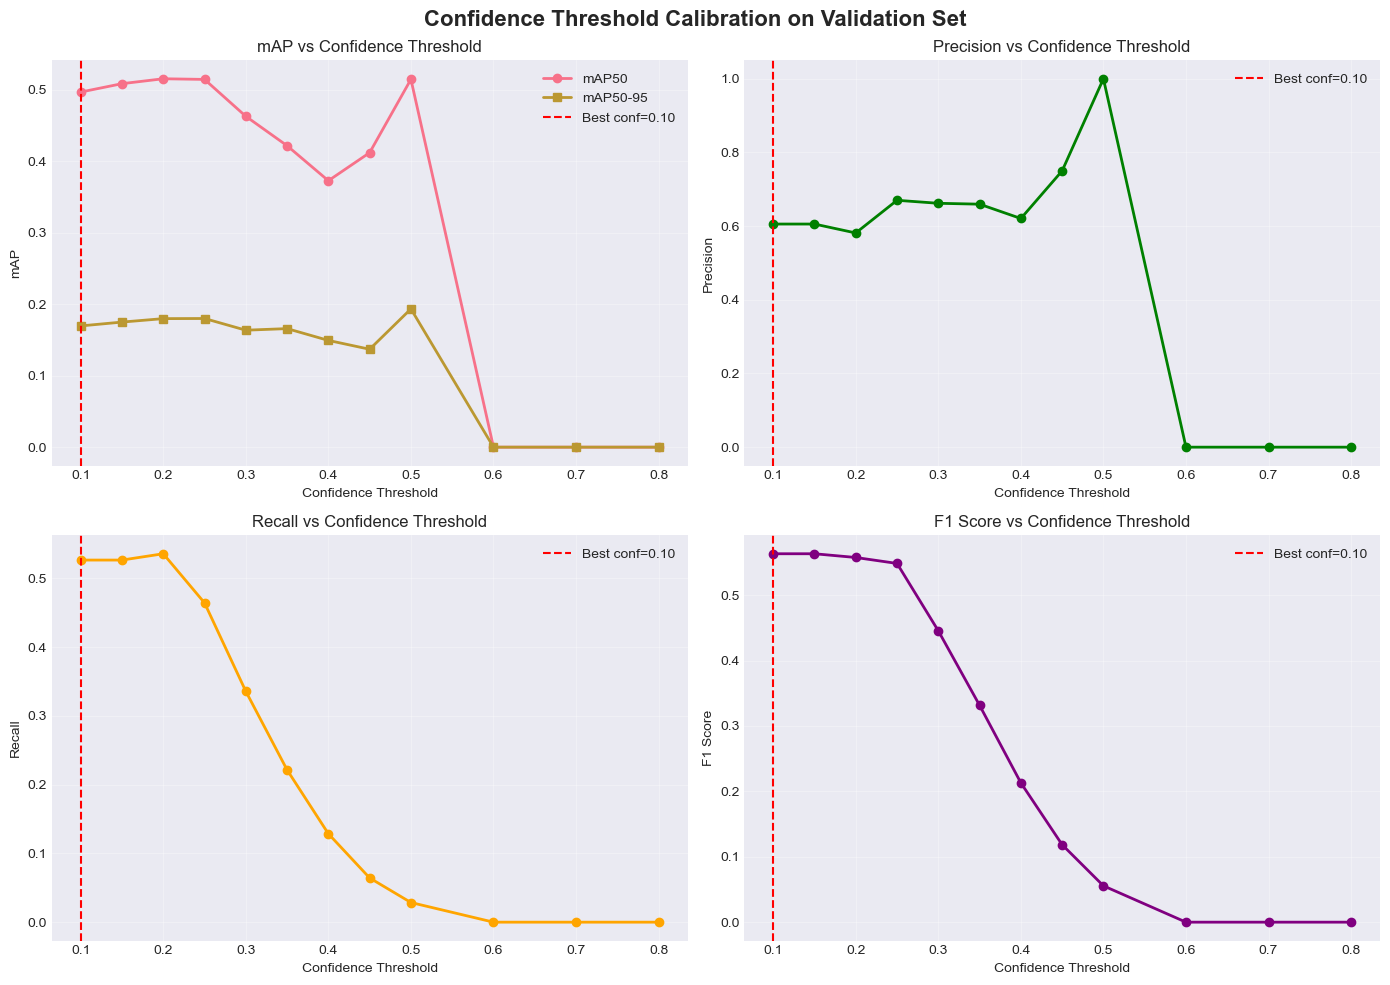

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Confidence Threshold Calibration on Validation Set', fontsize=16, fontweight='bold')

# Plot 1: mAP vs Confidence
ax = axes[0, 0]
ax.plot(conf_df['conf'], conf_df['mAP50'], 'o-', label='mAP50', linewidth=2, markersize=6)
ax.plot(conf_df['conf'], conf_df['mAP50-95'], 's-', label='mAP50-95', linewidth=2, markersize=6)
ax.axvline(x=best_conf, color='r', linestyle='--', label=f'Best conf={best_conf:.2f}')
ax.set_xlabel('Confidence Threshold')
ax.set_ylabel('mAP')
ax.set_title('mAP vs Confidence Threshold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Precision vs Confidence
ax = axes[0, 1]
ax.plot(conf_df['conf'], conf_df['precision'], 'o-', color='green', linewidth=2, markersize=6)
ax.axvline(x=best_conf, color='r', linestyle='--', label=f'Best conf={best_conf:.2f}')
ax.set_xlabel('Confidence Threshold')
ax.set_ylabel('Precision')
ax.set_title('Precision vs Confidence Threshold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Recall vs Confidence
ax = axes[1, 0]
ax.plot(conf_df['conf'], conf_df['recall'], 'o-', color='orange', linewidth=2, markersize=6)
ax.axvline(x=best_conf, color='r', linestyle='--', label=f'Best conf={best_conf:.2f}')
ax.set_xlabel('Confidence Threshold')
ax.set_ylabel('Recall')
ax.set_title('Recall vs Confidence Threshold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: F1 Score vs Confidence
ax = axes[1, 1]
ax.plot(conf_df['conf'], conf_df['f1'], 'o-', color='purple', linewidth=2, markersize=6)
ax.axvline(x=best_conf, color='r', linestyle='--', label=f'Best conf={best_conf:.2f}')
ax.set_xlabel('Confidence Threshold')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score vs Confidence Threshold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Log to wandb
if WANDB_AVAILABLE:
    wandb.log({"val_conf_calibration_plot": wandb.Image(fig)})

### 2.4 IoU Threshold Calibration on Validation Set

In [8]:
print("\n" + "=" * 80)
print("IOU THRESHOLD CALIBRATION (Validation Set)")
print("=" * 80)

# Test different IoU thresholds for NMS
iou_thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
iou_results = []

for iou in iou_thresholds:
    print(f"\nTesting iou={iou:.2f}...")
    
    results = model.val(
        data=DATASET_YAML,
        split='val',
        conf=best_conf,  # Use best confidence from previous calibration
        iou=iou,
        single_cls=SINGLE_CLS,
        imgsz=IMGSZ,
        batch=BATCH_SIZE,
        save_json=False,
        plots=False,
        verbose=False
    )
    
    iou_results.append({
        'iou': iou,
        'mAP50': float(results.box.map50) if hasattr(results.box, 'map50') else 0.0,
        'mAP50-95': float(results.box.map) if hasattr(results.box, 'map') else 0.0,
        'precision': float(results.box.p.mean()) if hasattr(results.box, 'p') else 0.0,
        'recall': float(results.box.r.mean()) if hasattr(results.box, 'r') else 0.0,
    })

iou_df = pd.DataFrame(iou_results)
print("\n" + iou_df.to_string(index=False))

# Find best IoU threshold based on mAP50
best_iou_idx = iou_df['mAP50'].idxmax()
best_iou = iou_df.loc[best_iou_idx, 'iou']
print(f"\n✓ Best IoU threshold: {best_iou:.2f} (mAP50={iou_df.loc[best_iou_idx, 'mAP50']:.4f})")

# Log to wandb
if WANDB_AVAILABLE:
    wandb.log({
        "val_best_iou": best_iou,
        "val_best_map50": iou_df.loc[best_iou_idx, 'mAP50']
    })
    
    # Log IoU calibration table
    wandb.log({"val_iou_calibration": wandb.Table(dataframe=iou_df)})


IOU THRESHOLD CALIBRATION (Validation Set)

Testing iou=0.30...
Ultralytics 8.4.2  Python-3.11.14 torch-2.9.1+cpu CPU (Intel Xeon E-2176G CPU @ 3.70GHz)
val: Fast image access  (ping: 0.10.0 ms, read: 518.0118.3 MB/s, size: 170.7 KB)
val: Scanning G:\2025-05-14_videos_annotated\labels.cache... 133 images, 365 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 498/498  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 1.6s/it 50.2s1.4ss
                   all        498        140      0.606      0.527      0.496       0.17
Speed: 1.2ms preprocess, 79.2ms inference, 0.0ms loss, 0.2ms postprocess per image

Testing iou=0.35...
Ultralytics 8.4.2  Python-3.11.14 torch-2.9.1+cpu CPU (Intel Xeon E-2176G CPU @ 3.70GHz)
val: Fast image access  (ping: 0.10.0 ms, read: 546.6106.5 MB/s, size: 155.0 KB)
val: Scanning G:\2025-05-14_videos_annotated\labels.cache... 133 images, 365 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 498/498  0.0s
   

### 2.5 Visualize IoU Threshold Impact

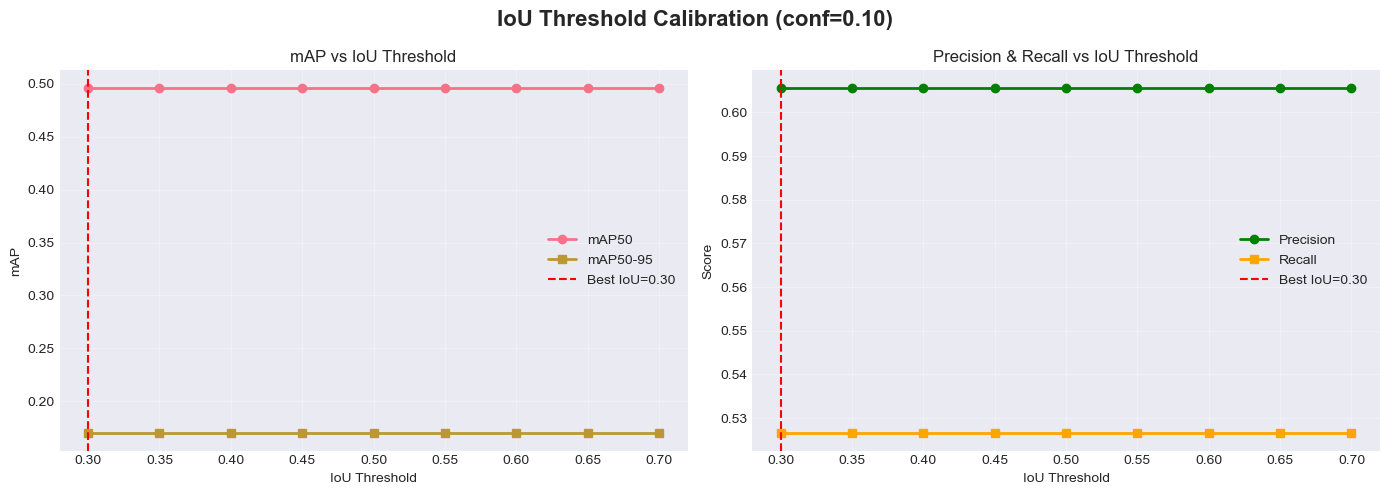


OPTIMAL HYPERPARAMETERS FROM VALIDATION
  Best Confidence Threshold: 0.10
  Best IoU Threshold: 0.30


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'IoU Threshold Calibration (conf={best_conf:.2f})', fontsize=16, fontweight='bold')

# Plot 1: mAP vs IoU
ax = axes[0]
ax.plot(iou_df['iou'], iou_df['mAP50'], 'o-', label='mAP50', linewidth=2, markersize=6)
ax.plot(iou_df['iou'], iou_df['mAP50-95'], 's-', label='mAP50-95', linewidth=2, markersize=6)
ax.axvline(x=best_iou, color='r', linestyle='--', label=f'Best IoU={best_iou:.2f}')
ax.set_xlabel('IoU Threshold')
ax.set_ylabel('mAP')
ax.set_title('mAP vs IoU Threshold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Precision & Recall vs IoU
ax = axes[1]
ax.plot(iou_df['iou'], iou_df['precision'], 'o-', label='Precision', linewidth=2, markersize=6, color='green')
ax.plot(iou_df['iou'], iou_df['recall'], 's-', label='Recall', linewidth=2, markersize=6, color='orange')
ax.axvline(x=best_iou, color='r', linestyle='--', label=f'Best IoU={best_iou:.2f}')
ax.set_xlabel('IoU Threshold')
ax.set_ylabel('Score')
ax.set_title('Precision & Recall vs IoU Threshold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Log to wandb
if WANDB_AVAILABLE:
    wandb.log({"val_iou_calibration_plot": wandb.Image(fig)})

print(f"\n{'='*80}")
print(f"OPTIMAL HYPERPARAMETERS FROM VALIDATION")
print(f"{'='*80}")
print(f"  Best Confidence Threshold: {best_conf:.2f}")
print(f"  Best IoU Threshold: {best_iou:.2f}")
print(f"{'='*80}")

### 2.6 IoU and Conf Score calibration on Val

In [14]:
# Check in val IoU and confidence score at the same time
print("\n" + "=" * 80)
print("IOU AND CONFIDENCE SCORE THRESHOLD CALIBRATION (Validation Set)")
print("=" * 80)

# Test different IoU thresholds for NMS
iou_thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
conf_scores = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
combined_results = []

total_combinations = len(iou_thresholds) * len(conf_scores)
current = 0

for iou in iou_thresholds:
    for conf in conf_scores:
        current += 1
        print(f"Testing [{current}/{total_combinations}] iou={iou:.2f}, conf={conf:.2f}...")
        
        res = model.val(
            data=DATASET_YAML,
            split='val',
            conf=conf,
            iou=iou,
            single_cls=SINGLE_CLS,
            imgsz=IMGSZ,
            batch=BATCH_SIZE,
            save_json=False,
            plots=False,
            verbose=False
        )
        
        combined_results.append({
            'iou': iou,
            'conf': conf,
            'mAP50': float(res.box.map50) if hasattr(res.box, 'map50') else 0.0,
            'mAP50-95': float(res.box.map) if hasattr(res.box, 'map') else 0.0,
            'precision': float(res.box.p.mean()) if hasattr(res.box, 'p') else 0.0,
            'recall': float(res.box.r.mean()) if hasattr(res.box, 'r') else 0.0,
        })

combined_df = pd.DataFrame(combined_results)
combined_df['f1'] = 2 * (combined_df['precision'] * combined_df['recall']) / (combined_df['precision'] + combined_df['recall'] + 1e-10)

print("\n" + combined_df.to_string(index=False))

# Find best combinations for different metrics
best_map50_idx = combined_df['mAP50'].idxmax()
best_map50_95_idx = combined_df['mAP50-95'].idxmax()
best_f1_idx = combined_df['f1'].idxmax()
best_precision_idx = combined_df['precision'].idxmax()
best_recall_idx = combined_df['recall'].idxmax()

print("\n" + "=" * 80)
print("BEST HYPERPARAMETER COMBINATIONS BY METRIC")
print("=" * 80)
print(f"Best for mAP50:     IoU={combined_df.loc[best_map50_idx, 'iou']:.2f}, Conf={combined_df.loc[best_map50_idx, 'conf']:.2f} → {combined_df.loc[best_map50_idx, 'mAP50']:.4f}")
print(f"Best for mAP50-95:  IoU={combined_df.loc[best_map50_95_idx, 'iou']:.2f}, Conf={combined_df.loc[best_map50_95_idx, 'conf']:.2f} → {combined_df.loc[best_map50_95_idx, 'mAP50-95']:.4f}")
print(f"Best for F1:        IoU={combined_df.loc[best_f1_idx, 'iou']:.2f}, Conf={combined_df.loc[best_f1_idx, 'conf']:.2f} → {combined_df.loc[best_f1_idx, 'f1']:.4f}")
print(f"Best for Precision: IoU={combined_df.loc[best_precision_idx, 'iou']:.2f}, Conf={combined_df.loc[best_precision_idx, 'conf']:.2f} → {combined_df.loc[best_precision_idx, 'precision']:.4f}")
print(f"Best for Recall:    IoU={combined_df.loc[best_recall_idx, 'iou']:.2f}, Conf={combined_df.loc[best_recall_idx, 'conf']:.2f} → {combined_df.loc[best_recall_idx, 'recall']:.4f}")

# Use mAP50 as primary metric for best overall combination
best_iou = combined_df.loc[best_map50_idx, 'iou']
best_conf = combined_df.loc[best_map50_idx, 'conf']

print(f"\n✓ Selected optimal combination (based on mAP50): IoU={best_iou:.2f}, Conf={best_conf:.2f}")

# Log to wandb
if WANDB_AVAILABLE:
    wandb.log({
        "val_best_iou": best_iou,
        "val_best_conf": best_conf,
        "val_best_map50": combined_df.loc[best_map50_idx, 'mAP50'],
        "val_best_f1": combined_df.loc[best_f1_idx, 'f1']
    })
    
    # Log combined calibration table
    wandb.log({"val_iou_conf_calibration": wandb.Table(dataframe=combined_df)})


IOU AND CONFIDENCE SCORE THRESHOLD CALIBRATION (Validation Set)
Testing [1/221] iou=0.30, conf=0.10...
Ultralytics 8.4.2  Python-3.11.14 torch-2.9.1+cpu CPU (Intel Xeon E-2176G CPU @ 3.70GHz)
YOLO26n summary (fused): 122 layers, 2,375,031 parameters, 0 gradients, 5.2 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 368.592.7 MB/s, size: 177.4 KB)
val: Scanning G:\2025-05-14_videos_annotated\labels.cache... 133 images, 365 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 498/498  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 1.7s/it 55.1s1.3ss
                   all        498        140      0.606      0.527      0.496       0.17
Speed: 1.3ms preprocess, 87.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Testing [2/221] iou=0.30, conf=0.15...
Ultralytics 8.4.2  Python-3.11.14 torch-2.9.1+cpu CPU (Intel Xeon E-2176G CPU @ 3.70GHz)
val: Fast image access  (ping: 0.10.0 ms, read: 624.381.4 MB/s, size: 162.6 KB

#### 2.7 Visualize Conf Score and IoU impact

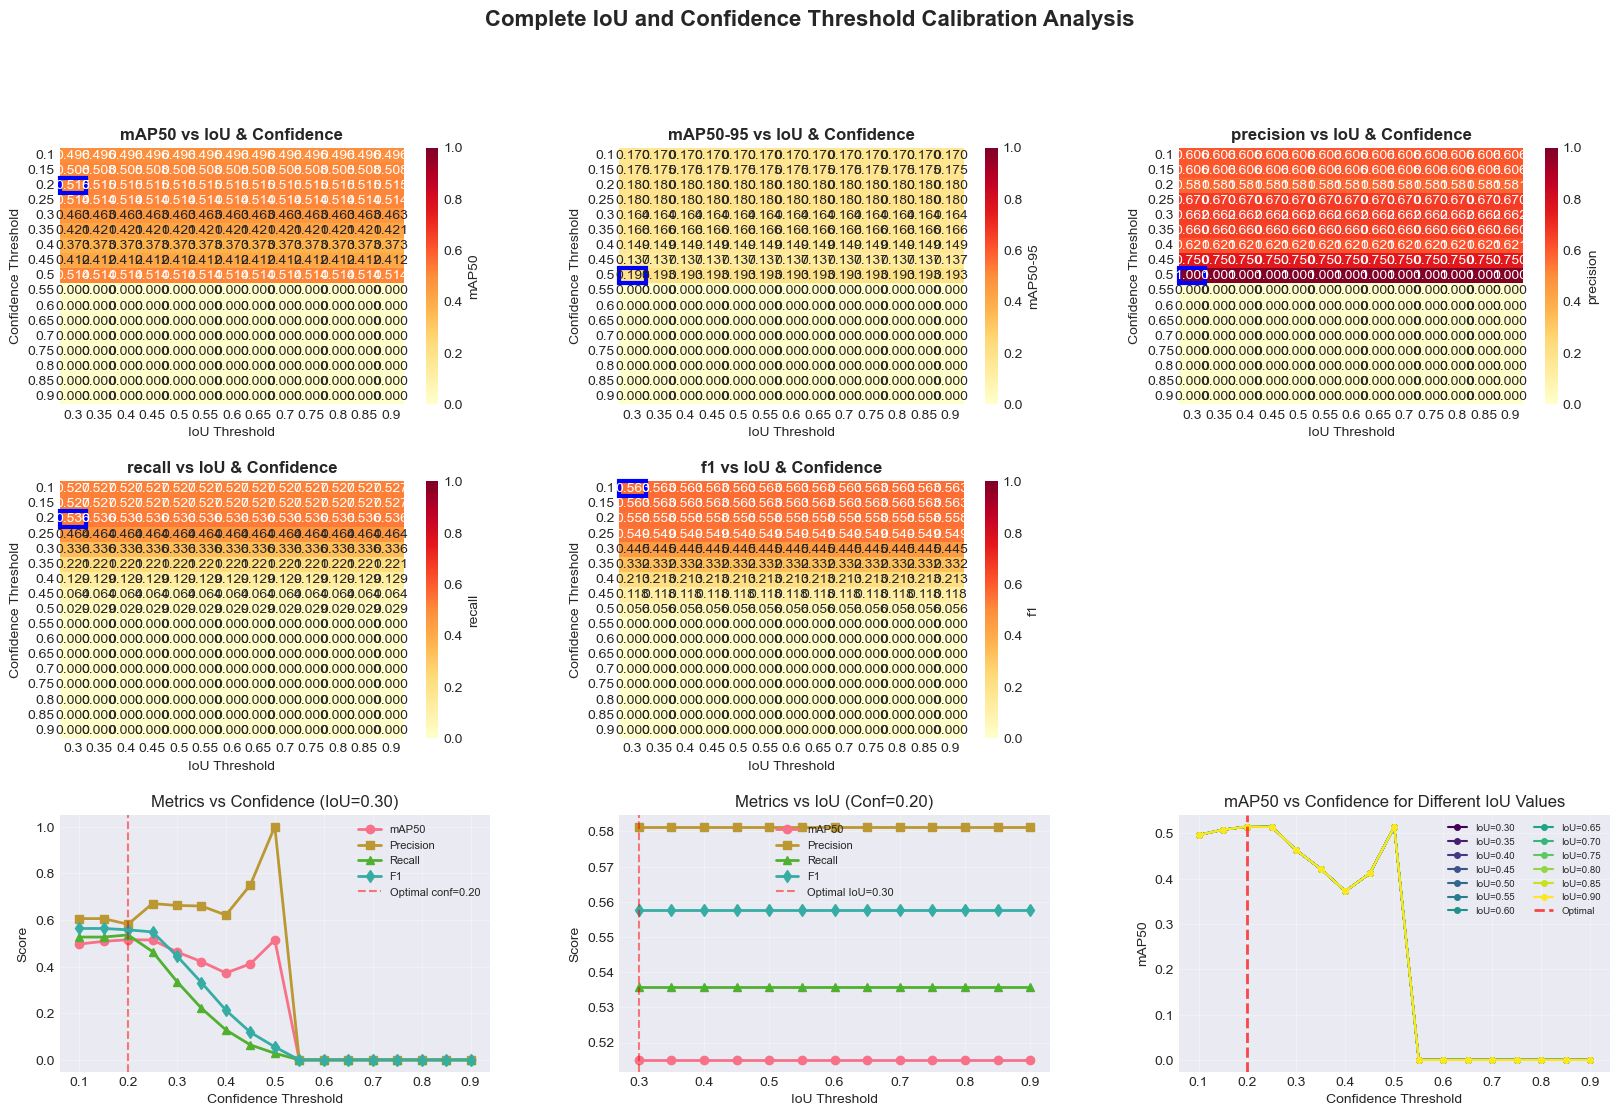


✓ Comprehensive calibration visualizations complete!


In [16]:
# Create pivot tables for heatmaps
metrics_to_plot = ['mAP50', 'mAP50-95', 'precision', 'recall', 'f1']
pivot_tables = {}

for metric in metrics_to_plot:
    pivot_tables[metric] = combined_df.pivot_table(
        values=metric, 
        index='conf', 
        columns='iou'
    )

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot heatmaps for each metric
for idx, metric in enumerate(metrics_to_plot):
    ax = fig.add_subplot(gs[idx // 3, idx % 3])
    
    sns.heatmap(
        pivot_tables[metric], 
        annot=True, 
        fmt='.3f', 
        cmap='YlOrRd', 
        cbar_kws={'label': metric},
        ax=ax,
        vmin=0,
        vmax=1
    )
    
    ax.set_title(f'{metric} vs IoU & Confidence', fontsize=12, fontweight='bold')
    ax.set_xlabel('IoU Threshold', fontsize=10)
    ax.set_ylabel('Confidence Threshold', fontsize=10)
    
    # Mark best value
    if metric == 'mAP50':
        best_row = combined_df.loc[best_map50_idx]
    elif metric == 'mAP50-95':
        best_row = combined_df.loc[best_map50_95_idx]
    elif metric == 'f1':
        best_row = combined_df.loc[best_f1_idx]
    elif metric == 'precision':
        best_row = combined_df.loc[best_precision_idx]
    else:  # recall
        best_row = combined_df.loc[best_recall_idx]
    
    # Find position in pivot table
    try:
        row_idx = list(pivot_tables[metric].index).index(best_row['conf'])
        col_idx = list(pivot_tables[metric].columns).index(best_row['iou'])
        ax.add_patch(plt.Rectangle((col_idx, row_idx), 1, 1, fill=False, 
                                   edgecolor='blue', lw=3, clip_on=False))
    except:
        pass

# Add line plots showing metric trends
ax_line1 = fig.add_subplot(gs[2, 0])
ax_line2 = fig.add_subplot(gs[2, 1])
ax_line3 = fig.add_subplot(gs[2, 2])

# Plot 1: All metrics at optimal IoU
optimal_iou_data = combined_df[combined_df['iou'] == best_iou]
ax_line1.plot(optimal_iou_data['conf'], optimal_iou_data['mAP50'], 'o-', label='mAP50', linewidth=2)
ax_line1.plot(optimal_iou_data['conf'], optimal_iou_data['precision'], 's-', label='Precision', linewidth=2)
ax_line1.plot(optimal_iou_data['conf'], optimal_iou_data['recall'], '^-', label='Recall', linewidth=2)
ax_line1.plot(optimal_iou_data['conf'], optimal_iou_data['f1'], 'd-', label='F1', linewidth=2)
ax_line1.axvline(x=best_conf, color='r', linestyle='--', alpha=0.5, label=f'Optimal conf={best_conf:.2f}')
ax_line1.set_xlabel('Confidence Threshold')
ax_line1.set_ylabel('Score')
ax_line1.set_title(f'Metrics vs Confidence (IoU={best_iou:.2f})')
ax_line1.legend(fontsize=8)
ax_line1.grid(True, alpha=0.3)

# Plot 2: All metrics at optimal Conf
optimal_conf_data = combined_df[combined_df['conf'] == best_conf]
ax_line2.plot(optimal_conf_data['iou'], optimal_conf_data['mAP50'], 'o-', label='mAP50', linewidth=2)
ax_line2.plot(optimal_conf_data['iou'], optimal_conf_data['precision'], 's-', label='Precision', linewidth=2)
ax_line2.plot(optimal_conf_data['iou'], optimal_conf_data['recall'], '^-', label='Recall', linewidth=2)
ax_line2.plot(optimal_conf_data['iou'], optimal_conf_data['f1'], 'd-', label='F1', linewidth=2)
ax_line2.axvline(x=best_iou, color='r', linestyle='--', alpha=0.5, label=f'Optimal IoU={best_iou:.2f}')
ax_line2.set_xlabel('IoU Threshold')
ax_line2.set_ylabel('Score')
ax_line2.set_title(f'Metrics vs IoU (Conf={best_conf:.2f})')
ax_line2.legend(fontsize=8)
ax_line2.grid(True, alpha=0.3)

# Plot 3: mAP50 for different IoU values across confidence
ax_line3.set_prop_cycle(plt.cycler('color', plt.cm.viridis(np.linspace(0, 1, len(iou_thresholds)))))
for iou_val in iou_thresholds:
    iou_data = combined_df[combined_df['iou'] == iou_val]
    ax_line3.plot(iou_data['conf'], iou_data['mAP50'], 'o-', label=f'IoU={iou_val:.2f}', linewidth=1.5, markersize=4)

ax_line3.axvline(x=best_conf, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Optimal')
ax_line3.set_xlabel('Confidence Threshold')
ax_line3.set_ylabel('mAP50')
ax_line3.set_title('mAP50 vs Confidence for Different IoU Values')
ax_line3.legend(fontsize=7, ncol=2, loc='best')
ax_line3.grid(True, alpha=0.3)

fig.suptitle('Complete IoU and Confidence Threshold Calibration Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

# Log to wandb
if WANDB_AVAILABLE:
    wandb.log({"val_combined_calibration_heatmaps": wandb.Image(fig)})

print("\n✓ Comprehensive calibration visualizations complete!")

## 3. Test Set Evaluation (Final Performance)

### 3.1 Test Set Evaluation with Optimized Parameters

In [ ]:
print("\n" + "=" * 80)
print("TEST SET EVALUATION WITH OPTIMIZED PARAMETERS")
print("=" * 80)
print(f"Using: conf={best_conf:.2f}, iou={best_iou:.2f}")

# Run test evaluation with optimized parameters and save outputs
test_results = model.val(
    data=DATASET_YAML,
    split='test',
    conf=best_conf,
    iou=best_iou,
    single_cls=SINGLE_CLS,
    imgsz=IMGSZ,
    batch=BATCH_SIZE,
    save_json=True,
    save_hybrid=False,
    plots=True,  # Generate plots
    verbose=True,
    project='DeTect-BMMS/runs',
    name=f'evaluation/{EXPERIMENT_NAME}_test'
)

# Extract test metrics
test_metrics = {
    'mAP50': float(test_results.box.map50) if hasattr(test_results.box, 'map50') else 0.0,
    'mAP50-95': float(test_results.box.map) if hasattr(test_results.box, 'map') else 0.0,
    'precision': float(test_results.box.p.mean()) if hasattr(test_results.box, 'p') else 0.0,
    'recall': float(test_results.box.r.mean()) if hasattr(test_results.box, 'r') else 0.0,
}

print(f"\n{'Metric':<20} {'Value':<10}")
print("-" * 30)
for metric, value in test_metrics.items():
    print(f"{metric:<20} {value:.4f}")

# Calculate F1 score
test_f1 = 2 * (test_metrics['precision'] * test_metrics['recall']) / (test_metrics['precision'] + test_metrics['recall'] + 1e-10)
test_metrics['f1'] = test_f1
print(f"{'F1 Score':<20} {test_f1:.4f}")

# Log to wandb
if WANDB_AVAILABLE:
    wandb.log({
        "test_metrics": test_metrics,
        "test_conf": best_conf,
        "test_iou": best_iou
    })

print("\n✓ Test evaluation complete!")

### 3.2 Detailed Test Set Analysis with Multiple Thresholds

In [ ]:
print("\n" + "=" * 80)
print("TEST SET - CONFIDENCE THRESHOLD ANALYSIS")
print("=" * 80)

# Test a range of confidence thresholds around the optimal
test_conf_range = [best_conf - 0.1, best_conf - 0.05, best_conf, best_conf + 0.05, best_conf + 0.1]
test_conf_range = [max(0.1, min(0.9, c)) for c in test_conf_range]  # Keep in valid range

test_conf_results = []

for conf in test_conf_range:
    print(f"\nTesting conf={conf:.2f} on test set...")
    
    results = model.val(
        data=DATASET_YAML,
        split='test',
        conf=conf,
        iou=best_iou,
        single_cls=SINGLE_CLS,
        imgsz=IMGSZ,
        batch=BATCH_SIZE,
        save_json=False,
        plots=False,
        verbose=False
    )
    
    test_conf_results.append({
        'conf': conf,
        'mAP50': float(results.box.map50) if hasattr(results.box, 'map50') else 0.0,
        'mAP50-95': float(results.box.map) if hasattr(results.box, 'map') else 0.0,
        'precision': float(results.box.p.mean()) if hasattr(results.box, 'p') else 0.0,
        'recall': float(results.box.r.mean()) if hasattr(results.box, 'r') else 0.0,
    })

test_conf_df = pd.DataFrame(test_conf_results)
test_conf_df['f1'] = 2 * (test_conf_df['precision'] * test_conf_df['recall']) / (test_conf_df['precision'] + test_conf_df['recall'] + 1e-10)

print("\n" + test_conf_df.to_string(index=False))

# Log to wandb
if WANDB_AVAILABLE:
    wandb.log({"test_conf_analysis": wandb.Table(dataframe=test_conf_df)})

### 3.3 Visualize Test Set Performance

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Test Set Performance Analysis (IoU={best_iou:.2f})', fontsize=16, fontweight='bold')

# Plot 1: Metrics vs Confidence on Test Set
ax = axes[0, 0]
ax.plot(test_conf_df['conf'], test_conf_df['precision'], 'o-', label='Precision', linewidth=2)
ax.plot(test_conf_df['conf'], test_conf_df['recall'], 's-', label='Recall', linewidth=2)
ax.plot(test_conf_df['conf'], test_conf_df['f1'], '^-', label='F1', linewidth=2)
ax.axvline(x=best_conf, color='r', linestyle='--', alpha=0.5, label=f'Optimal conf={best_conf:.2f}')
ax.set_xlabel('Confidence Threshold')
ax.set_ylabel('Score')
ax.set_title('Test Set: Precision, Recall, F1 vs Confidence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: mAP vs Confidence on Test Set
ax = axes[0, 1]
ax.plot(test_conf_df['conf'], test_conf_df['mAP50'], 'o-', label='mAP50', linewidth=2)
ax.plot(test_conf_df['conf'], test_conf_df['mAP50-95'], 's-', label='mAP50-95', linewidth=2)
ax.axvline(x=best_conf, color='r', linestyle='--', alpha=0.5, label=f'Optimal conf={best_conf:.2f}')
ax.set_xlabel('Confidence Threshold')
ax.set_ylabel('mAP')
ax.set_title('Test Set: mAP vs Confidence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Val vs Test Comparison
ax = axes[1, 0]
metrics_comparison = pd.DataFrame({
    'Metric': ['mAP50', 'mAP50-95', 'Precision', 'Recall', 'F1'],
    'Validation': [
        conf_df.loc[best_conf_idx, 'mAP50'],
        conf_df.loc[best_conf_idx, 'mAP50-95'],
        conf_df.loc[best_conf_idx, 'precision'],
        conf_df.loc[best_conf_idx, 'recall'],
        conf_df.loc[best_conf_idx, 'f1']
    ],
    'Test': [
        test_metrics['mAP50'],
        test_metrics['mAP50-95'],
        test_metrics['precision'],
        test_metrics['recall'],
        test_metrics['f1']
    ]
})

x = np.arange(len(metrics_comparison['Metric']))
width = 0.35
ax.bar(x - width/2, metrics_comparison['Validation'], width, label='Validation', alpha=0.8)
ax.bar(x + width/2, metrics_comparison['Test'], width, label='Test', alpha=0.8)
ax.set_ylabel('Score')
ax.set_title('Validation vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics_comparison['Metric'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Summary Statistics Table
ax = axes[1, 1]
ax.axis('off')

summary_text = f"""
MODEL EVALUATION SUMMARY

Experiment: {EXPERIMENT_NAME}

Optimized Hyperparameters:
  Confidence: {best_conf:.2f}
  IoU: {best_iou:.2f}

Test Set Performance:
  mAP50:      {test_metrics['mAP50']:.4f}
  mAP50-95:   {test_metrics['mAP50-95']:.4f}
  Precision:  {test_metrics['precision']:.4f}
  Recall:     {test_metrics['recall']:.4f}
  F1 Score:   {test_metrics['f1']:.4f}

Validation Set Performance:
  mAP50:      {conf_df.loc[best_conf_idx, 'mAP50']:.4f}
  mAP50-95:   {conf_df.loc[best_conf_idx, 'mAP50-95']:.4f}
  Precision:  {conf_df.loc[best_conf_idx, 'precision']:.4f}
  Recall:     {conf_df.loc[best_conf_idx, 'recall']:.4f}
  F1 Score:   {conf_df.loc[best_conf_idx, 'f1']:.4f}
"""

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Log to wandb
if WANDB_AVAILABLE:
    wandb.log({"test_performance_summary": wandb.Image(fig)})
    wandb.log({"val_vs_test_comparison": wandb.Table(dataframe=metrics_comparison)})

## 4. Generate Predictions with Visualizations

### 4.1 Run Predictions on Test Set with Optimized Parameters

In [ ]:
print("\n" + "=" * 80)
print("GENERATING PREDICTIONS ON TEST SET")
print("=" * 80)

# Load test images
TEST_FILE = Path("../dataset/csvs/splits/test.txt")

if not TEST_FILE.exists():
    print(f"Warning: Test file not found at {TEST_FILE}")
    test_images = []
else:
    with open(TEST_FILE, 'r') as f:
        test_images = [Path(line.strip()) for line in f.readlines() if line.strip()]

print(f"Found {len(test_images)} test images")

# Run predictions and save visualizations (select a subset for visualization)
if len(test_images) > 0:
    # Predict on a sample of images to save visualizations
    sample_size = min(50, len(test_images))
    sample_indices = np.random.choice(len(test_images), sample_size, replace=False)
    sample_images = [test_images[i] for i in sample_indices]
    
    print(f"Running predictions on {sample_size} sample images with visualizations...")
    
    results = model.predict(
        source=[str(img) for img in sample_images],
        conf=best_conf,
        iou=best_iou,
        save=True,
        save_txt=True,
        save_conf=True,
        project='DeTect-BMMS/runs',
        name=f'predict/{EXPERIMENT_NAME}_test_visual',
        exist_ok=True,
        show_labels=True,
        show_conf=True,
        line_width=2
    )
    
    print(f"✓ Predictions saved to: DeTect-BMMS/runs/predict/{EXPERIMENT_NAME}_test_visual")
else:
    print("No test images found for prediction")

## 5. Export Results and Close Wandb

In [ ]:
from datetime import datetime

# Create evaluation summary
evaluation_summary = {
    'experiment_name': EXPERIMENT_NAME,
    'model_path': str(model_path),
    'evaluation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'single_cls': SINGLE_CLS,
    
    # Optimized hyperparameters
    'best_conf_threshold': best_conf,
    'best_iou_threshold': best_iou,
    
    # Validation metrics
    'val_mAP50': float(conf_df.loc[best_conf_idx, 'mAP50']),
    'val_mAP50_95': float(conf_df.loc[best_conf_idx, 'mAP50-95']),
    'val_precision': float(conf_df.loc[best_conf_idx, 'precision']),
    'val_recall': float(conf_df.loc[best_conf_idx, 'recall']),
    'val_f1': float(conf_df.loc[best_conf_idx, 'f1']),
    
    # Test metrics
    'test_mAP50': test_metrics['mAP50'],
    'test_mAP50_95': test_metrics['mAP50-95'],
    'test_precision': test_metrics['precision'],
    'test_recall': test_metrics['recall'],
    'test_f1': test_metrics['f1'],
}

# Save to JSON
import json
output_file = Path(f"evaluation_{EXPERIMENT_NAME}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(output_file, 'w') as f:
    json.dump(evaluation_summary, f, indent=2)

print("\n" + "=" * 80)
print("EVALUATION SUMMARY")
print("=" * 80)
for key, value in evaluation_summary.items():
    if isinstance(value, float):
        print(f"{key:<25}: {value:.4f}")
    else:
        print(f"{key:<25}: {value}")

print(f"\n✓ Evaluation summary saved to: {output_file}")

# Log final summary to wandb
if WANDB_AVAILABLE:
    wandb.log({"evaluation_summary": evaluation_summary})
    wandb.log({"summary_table": wandb.Table(
        data=[[k, v] for k, v in evaluation_summary.items()],
        columns=["Parameter", "Value"]
    )})
    
    print("\n✓ Closing wandb run...")
    wandb.finish()
    print("✓ Wandb run finished!")

print("\n" + "=" * 80)
print("✓✓✓ EVALUATION COMPLETE ✓✓✓")
print("=" * 80)